In [1]:
!unzip 개고양이.zip

Archive:  개고양이.zip
  inflating: training_set/cats/cat.1.jpg  
  inflating: training_set/cats/cat.10.jpg  
  inflating: training_set/cats/cat.100.jpg  
  inflating: training_set/cats/cat.11.jpg  
  inflating: training_set/cats/cat.12.jpg  
  inflating: training_set/cats/cat.13.jpg  
  inflating: training_set/cats/cat.14.jpg  
  inflating: training_set/cats/cat.15.jpg  
  inflating: training_set/cats/cat.16.jpg  
  inflating: training_set/cats/cat.17.jpg  
  inflating: training_set/cats/cat.18.jpg  
  inflating: training_set/cats/cat.19.jpg  
  inflating: training_set/cats/cat.2.jpg  
  inflating: training_set/cats/cat.20.jpg  
  inflating: training_set/cats/cat.21.jpg  
  inflating: training_set/cats/cat.22.jpg  
  inflating: training_set/cats/cat.23.jpg  
  inflating: training_set/cats/cat.24.jpg  
  inflating: training_set/cats/cat.25.jpg  
  inflating: training_set/cats/cat.26.jpg  
  inflating: training_set/cats/cat.27.jpg  
  inflating: training_set/cats/cat.28.jpg  
  inflating: t

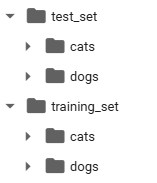

폴더를 캡쳐

이후 캡쳐한 사진을 chatGPT에 올린후

---
training_set 안에 cats, dogs가 있고 각각 개와 고양이 사진이 .jpg으로 있어.
그리고 test_set 안에 cats, dogs가 있고 각각 개와 고양이 사진이 .jpg으로 있어.

파이토치 CNN으로 train 및 test 하는 코드를 주고 평가지표는 f1 score줘.

tqdm 적용하고, 학습 도중에 train loss, train f1 score, test f1 score 출력하도록 전체 코드를 줘.

---

검색

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score

# 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# 데이터 경로
train_dir = "./training_set"
test_dir = "./test_set"

# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 데이터셋 및 데이터로더
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델 정의 (pretrained ResNet18)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)

# 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# F1 스코어 계산 함수
def calculate_f1(loader, model):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return f1_score(all_labels, all_preds, average="macro")

# 학습
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    all_train_preds, all_train_labels = [], []

    # Training Loop
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

            tepoch.set_postfix(loss=loss.item())

    # Epoch metrics
    train_f1 = f1_score(all_train_labels, all_train_preds, average="macro")
    test_f1 = calculate_f1(test_loader, model)
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss/len(train_loader):.4f}, Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}")

print("Training complete.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.2MB/s]
Epoch 1/10: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s, loss=0.624]


Epoch 1/10 - Train Loss: 0.7141, Train F1: 0.7396, Test F1: 0.7869


Epoch 2/10: 100%|██████████| 7/7 [00:00<00:00,  8.34it/s, loss=0.675]


Epoch 2/10 - Train Loss: 0.5678, Train F1: 0.8534, Test F1: 0.6031


Epoch 3/10: 100%|██████████| 7/7 [00:00<00:00,  8.84it/s, loss=0.151]


Epoch 3/10 - Train Loss: 0.1842, Train F1: 0.9049, Test F1: 0.8200


Epoch 4/10: 100%|██████████| 7/7 [00:00<00:00,  8.83it/s, loss=0.139]


Epoch 4/10 - Train Loss: 0.0954, Train F1: 0.9700, Test F1: 0.7796


Epoch 5/10: 100%|██████████| 7/7 [00:00<00:00,  9.09it/s, loss=0.0519]


Epoch 5/10 - Train Loss: 0.0631, Train F1: 0.9900, Test F1: 0.7058


Epoch 6/10: 100%|██████████| 7/7 [00:00<00:00,  9.05it/s, loss=0.0177]


Epoch 6/10 - Train Loss: 0.0111, Train F1: 1.0000, Test F1: 0.7292


Epoch 7/10: 100%|██████████| 7/7 [00:00<00:00,  9.08it/s, loss=0.166]


Epoch 7/10 - Train Loss: 0.0410, Train F1: 0.9850, Test F1: 0.8332


Epoch 8/10: 100%|██████████| 7/7 [00:00<00:00,  7.26it/s, loss=8.1e-5]


Epoch 8/10 - Train Loss: 0.0097, Train F1: 0.9950, Test F1: 0.7735


Epoch 9/10: 100%|██████████| 7/7 [00:01<00:00,  6.44it/s, loss=1.23]


Epoch 9/10 - Train Loss: 0.2403, Train F1: 0.9600, Test F1: 0.8240


Epoch 10/10: 100%|██████████| 7/7 [00:00<00:00,  8.11it/s, loss=0.356]


Epoch 10/10 - Train Loss: 0.2183, Train F1: 0.9350, Test F1: 0.6711
Training complete.
